1.

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
X = np.load("moon-all-input.npy")
y = np.load("moon-all-output.npy")

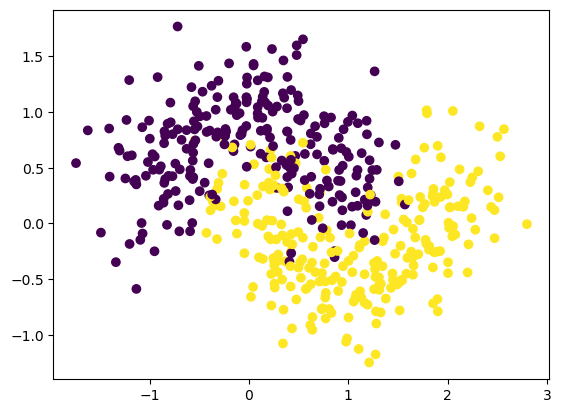

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

2.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

In [5]:
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.84
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.904


3.

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier

k = 3000

base_stump = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_clf = AdaBoostClassifier(
    base_stump, n_estimators=k,
    algorithm="SAMME", learning_rate=1, random_state=42
)

ada_clf.fit(X_train, y_train)

classifiers = {}
alphas = []
instance_weights = []
weighted_errors = []
train_accuracies = []
test_accuracies = []
train_predictions = list(ada_clf.staged_predict(X_train))
test_predictions = list(ada_clf.staged_predict(X_test))

for k, (estimator, alpha) in enumerate(zip(ada_clf.estimators_, ada_clf.estimator_weights_)):

    classifiers[k] = estimator

    alphas.append(alpha)
    instance_weights.append(ada_clf.estimator_errors_[k])

    weighted_error = ada_clf.estimator_errors_[k]
    weighted_errors.append(weighted_error)

    train_accuracy = accuracy_score(y_train, train_predictions[k])
    train_accuracies.append(train_accuracy)

    test_accuracy = accuracy_score(y_test, test_predictions[k])
    test_accuracies.append(test_accuracy)


4.

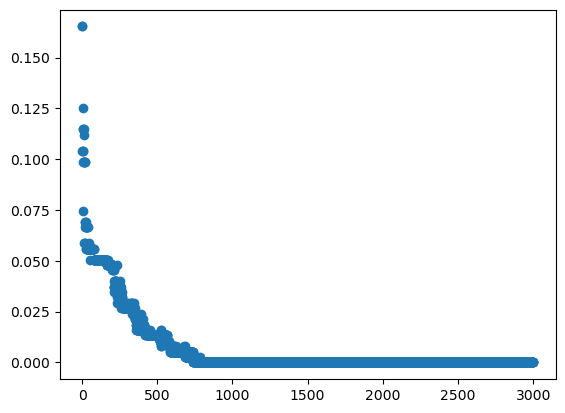

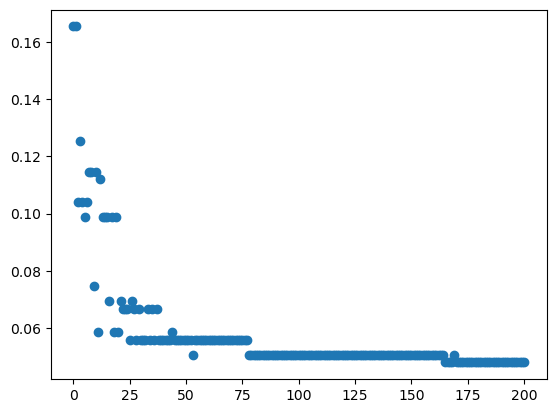

In [7]:
plt.scatter([i for i in range(k+1)], [1-accuracy for accuracy in train_accuracies])
plt.show()

plt.scatter([i for i in range(201)], [1-accuracy for accuracy in train_accuracies[:201]])
plt.show()

The error rate of the model on the training declines as more ensemble models are added. This is expected behavior as the models are able to better fit in later iterations.

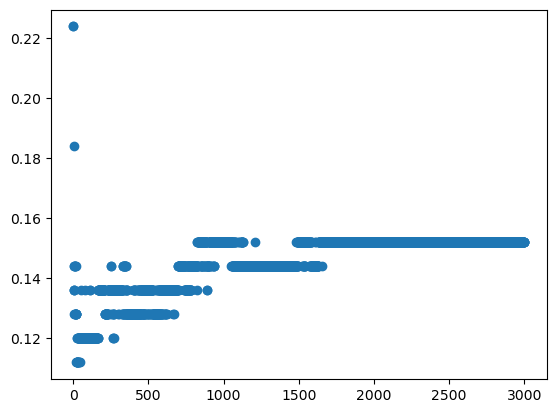

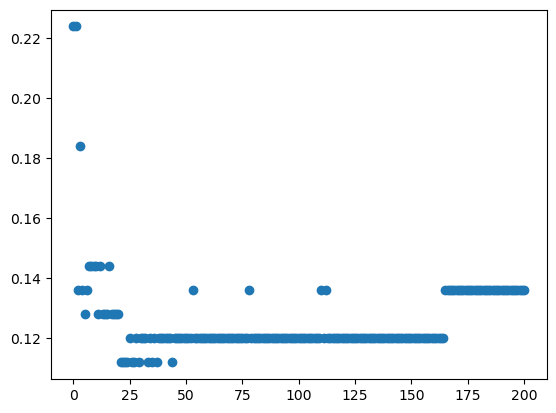

In [8]:
plt.scatter([i for i in range(k+1)], [1-accuracy for accuracy in test_accuracies])
plt.show()

plt.scatter([i for i in range(201)], [1-accuracy for accuracy in test_accuracies[:201]])
plt.show()

The error rate of the model on the test data steeply declines on the test data to 0.12 but increases to ~0.15 as the models may be overfitting in later iterations.

5.

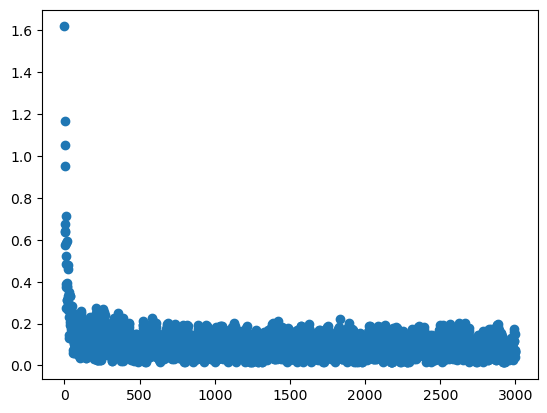

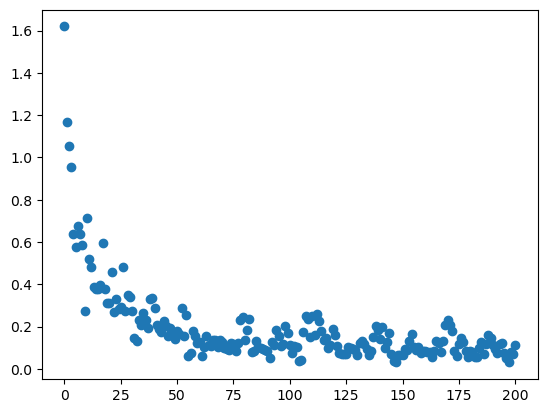

In [9]:
plt.scatter([i for i in range(k+1)], alphas)
plt.show()

plt.scatter([i for i in range(201)], alphas[:201])
plt.show()

6.

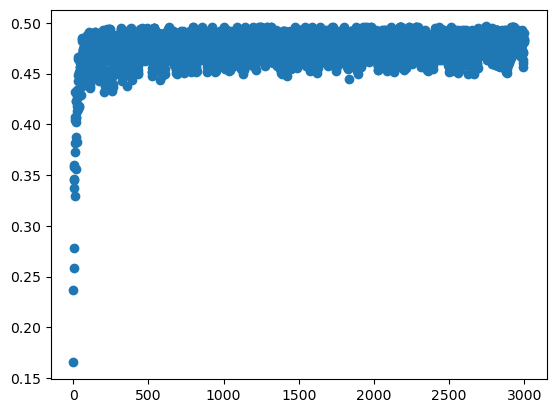

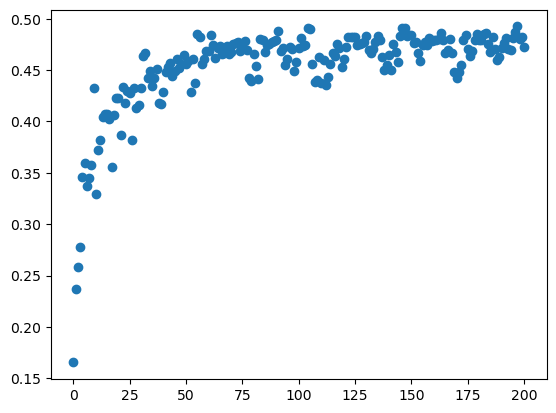

In [10]:
plt.scatter([i for i in range(k+1)], weighted_errors)
plt.show()

plt.scatter([i for i in range(201)], weighted_errors[:201])
plt.show()

7.

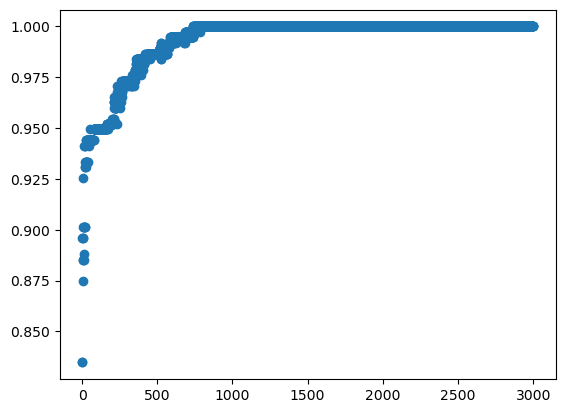

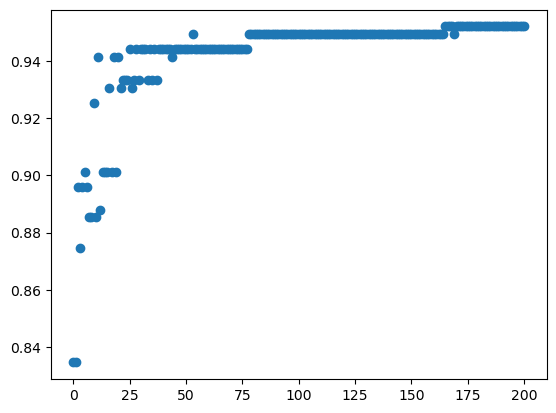

In [11]:
plt.scatter([i for i in range(k+1)], train_accuracies)
plt.show()

plt.scatter([i for i in range(201)], train_accuracies[:201])
plt.show()

8.

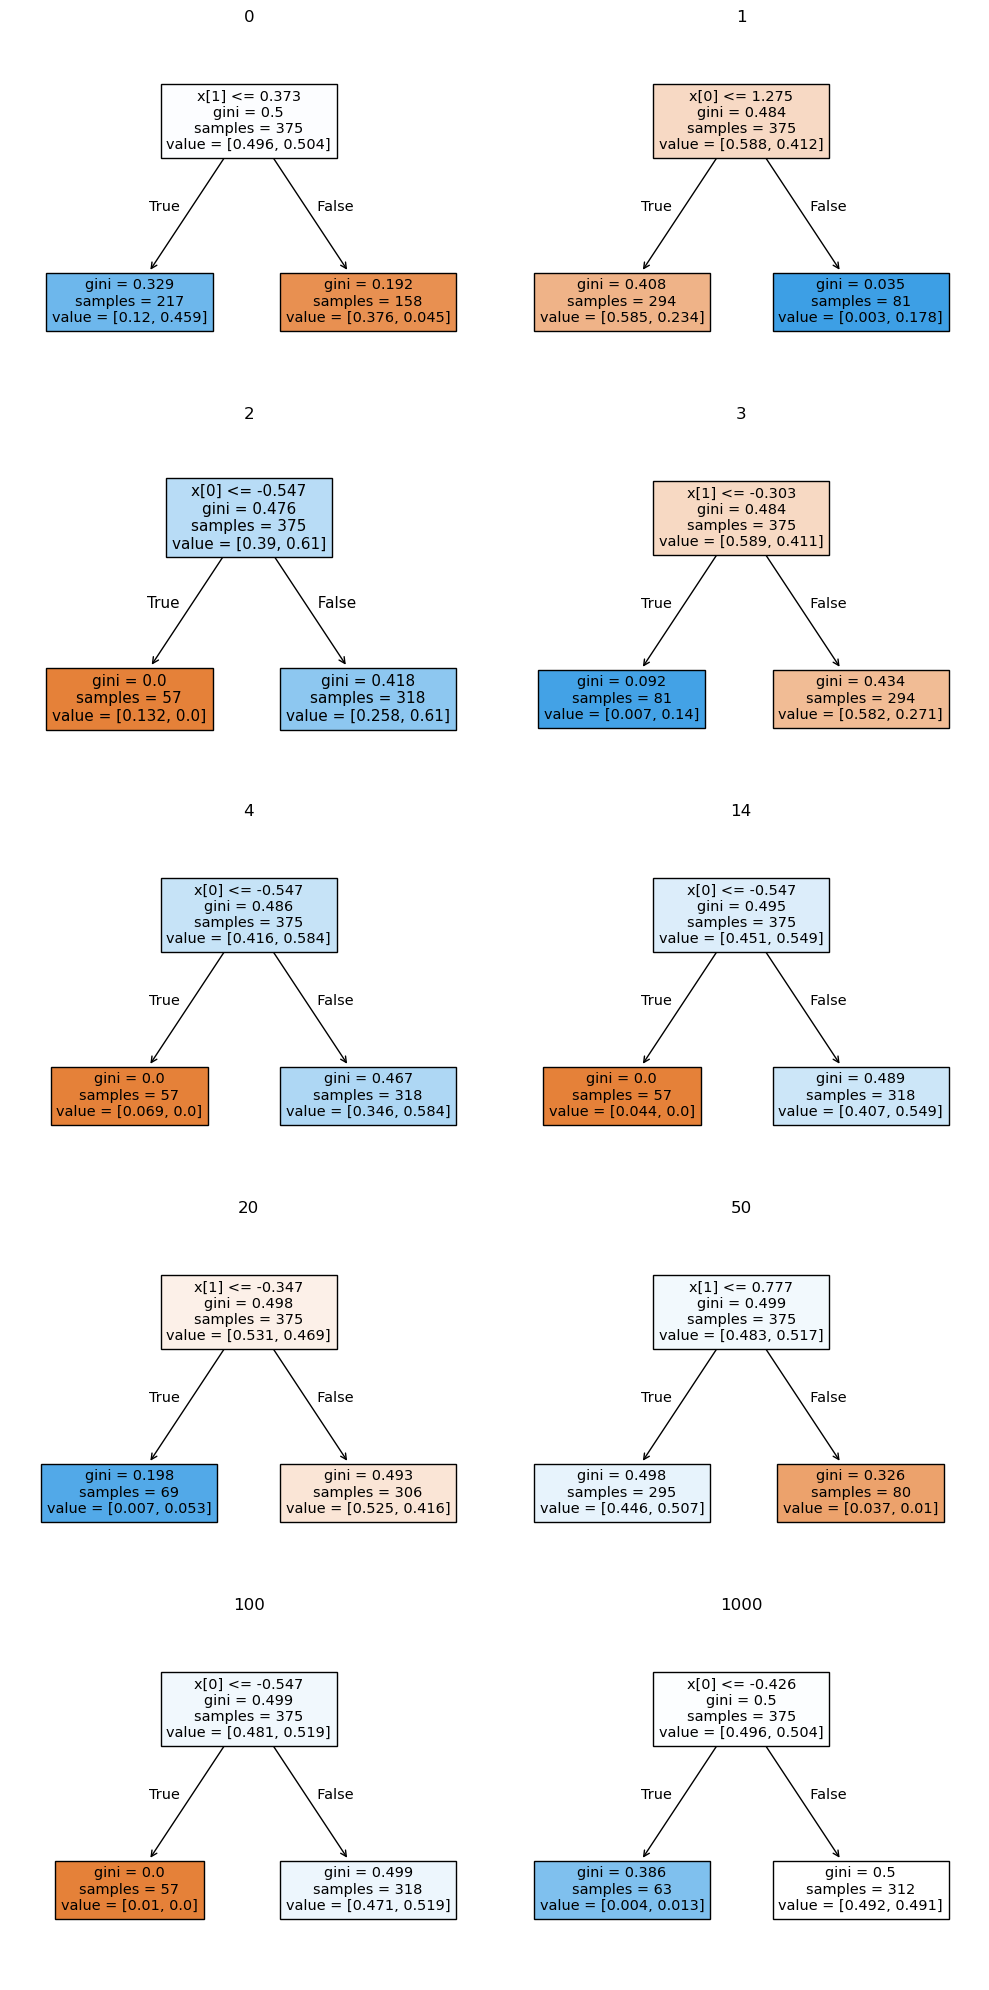

In [12]:
plt.figure(figsize=(10,20))
for i, idx in enumerate([0, 1, 2, 3, 4, 14, 20, 50, 100, 1000]):
    plt.subplot(5, 2, i+1)
    plot_tree(classifiers[idx], filled=True)
    plt.title(f"{idx}")
plt.tight_layout()
plt.show()

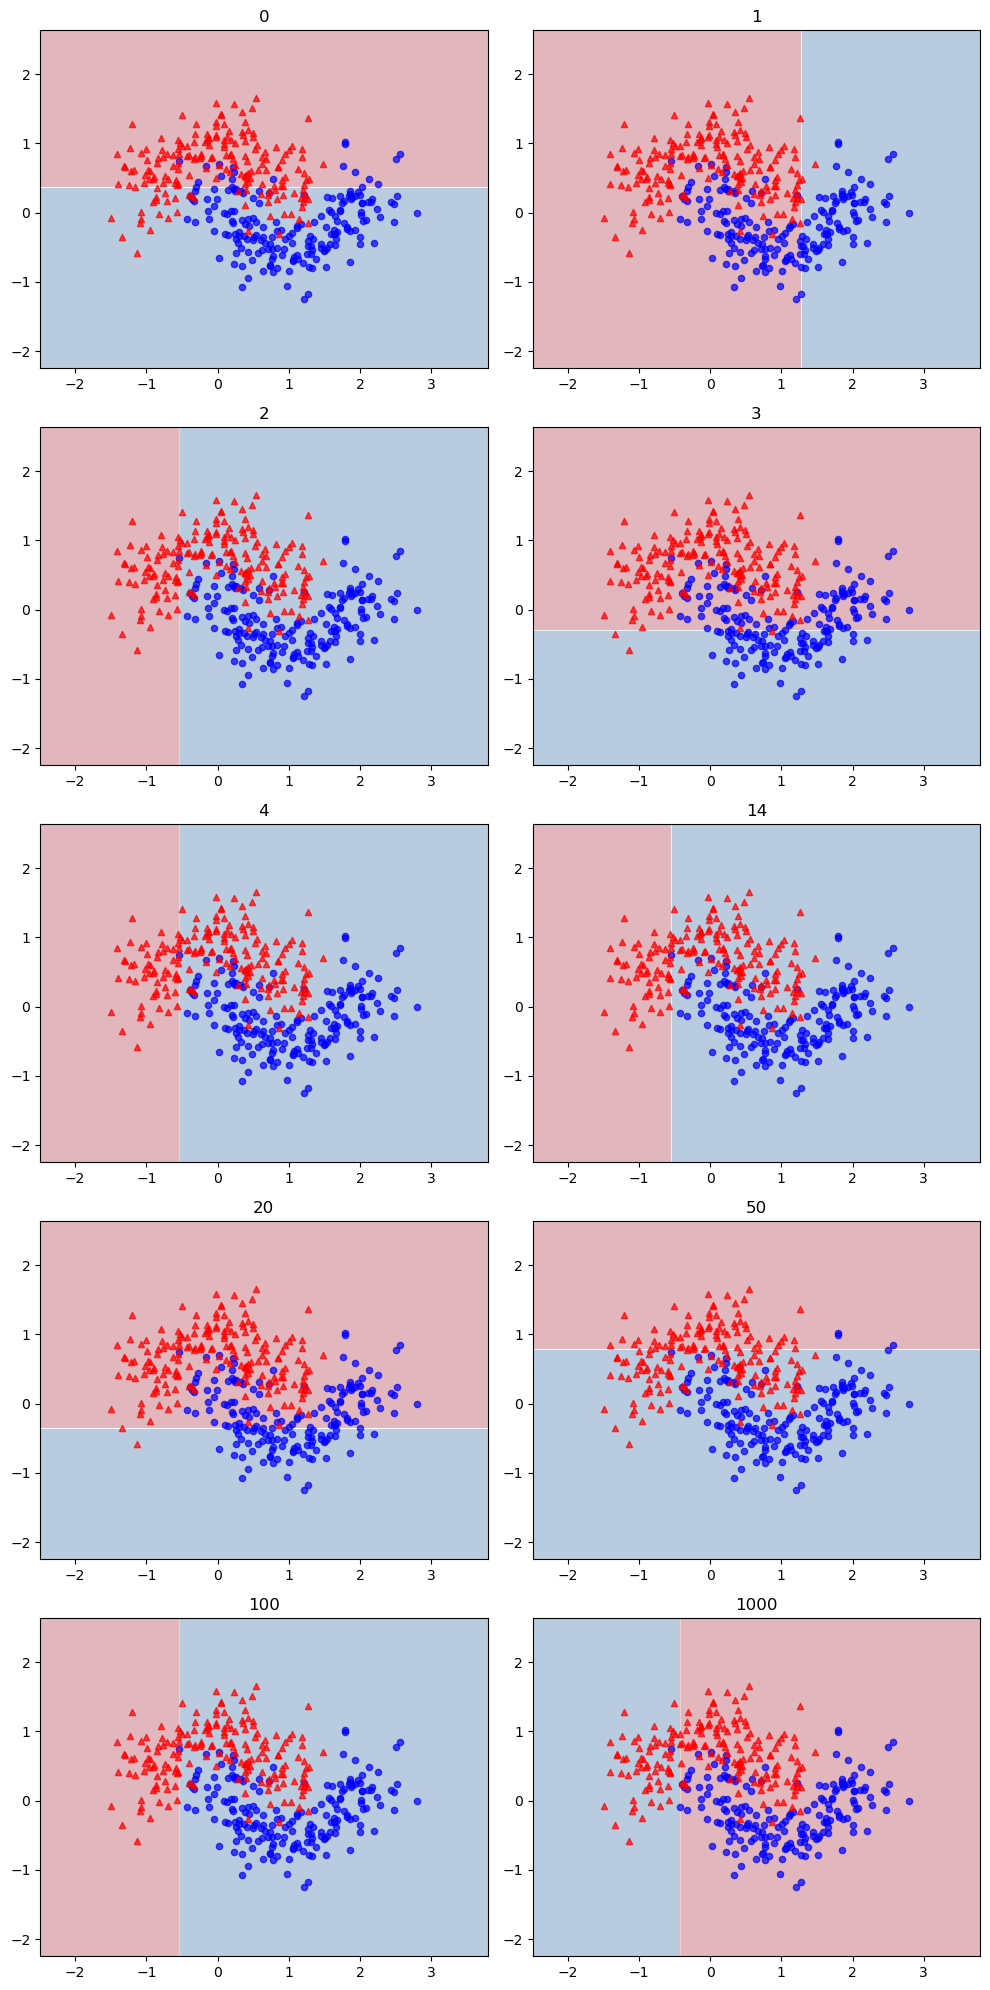

In [24]:
plt.figure(figsize=(10, 20))
for i, idx in enumerate([0, 1, 2, 3, 4, 14, 20, 50, 100, 1000]):
    plt.subplot(5, 2, i+1)
    
    # Create a mesh grid to plot the decision boundary
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    Z = classifiers[idx].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

    weights = instance_weights[idx]
    normalized_weights = weights / np.max(weights)
    normalized_weights *= 20

    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                c='blue', marker='o', label='Class 0',
                s=normalized_weights, alpha=0.7)
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
                c='red', marker='^', label='Class 1',
                s=normalized_weights, alpha=0.7)
    
    plt.title(f"{idx}")
    plt.tight_layout()

9.

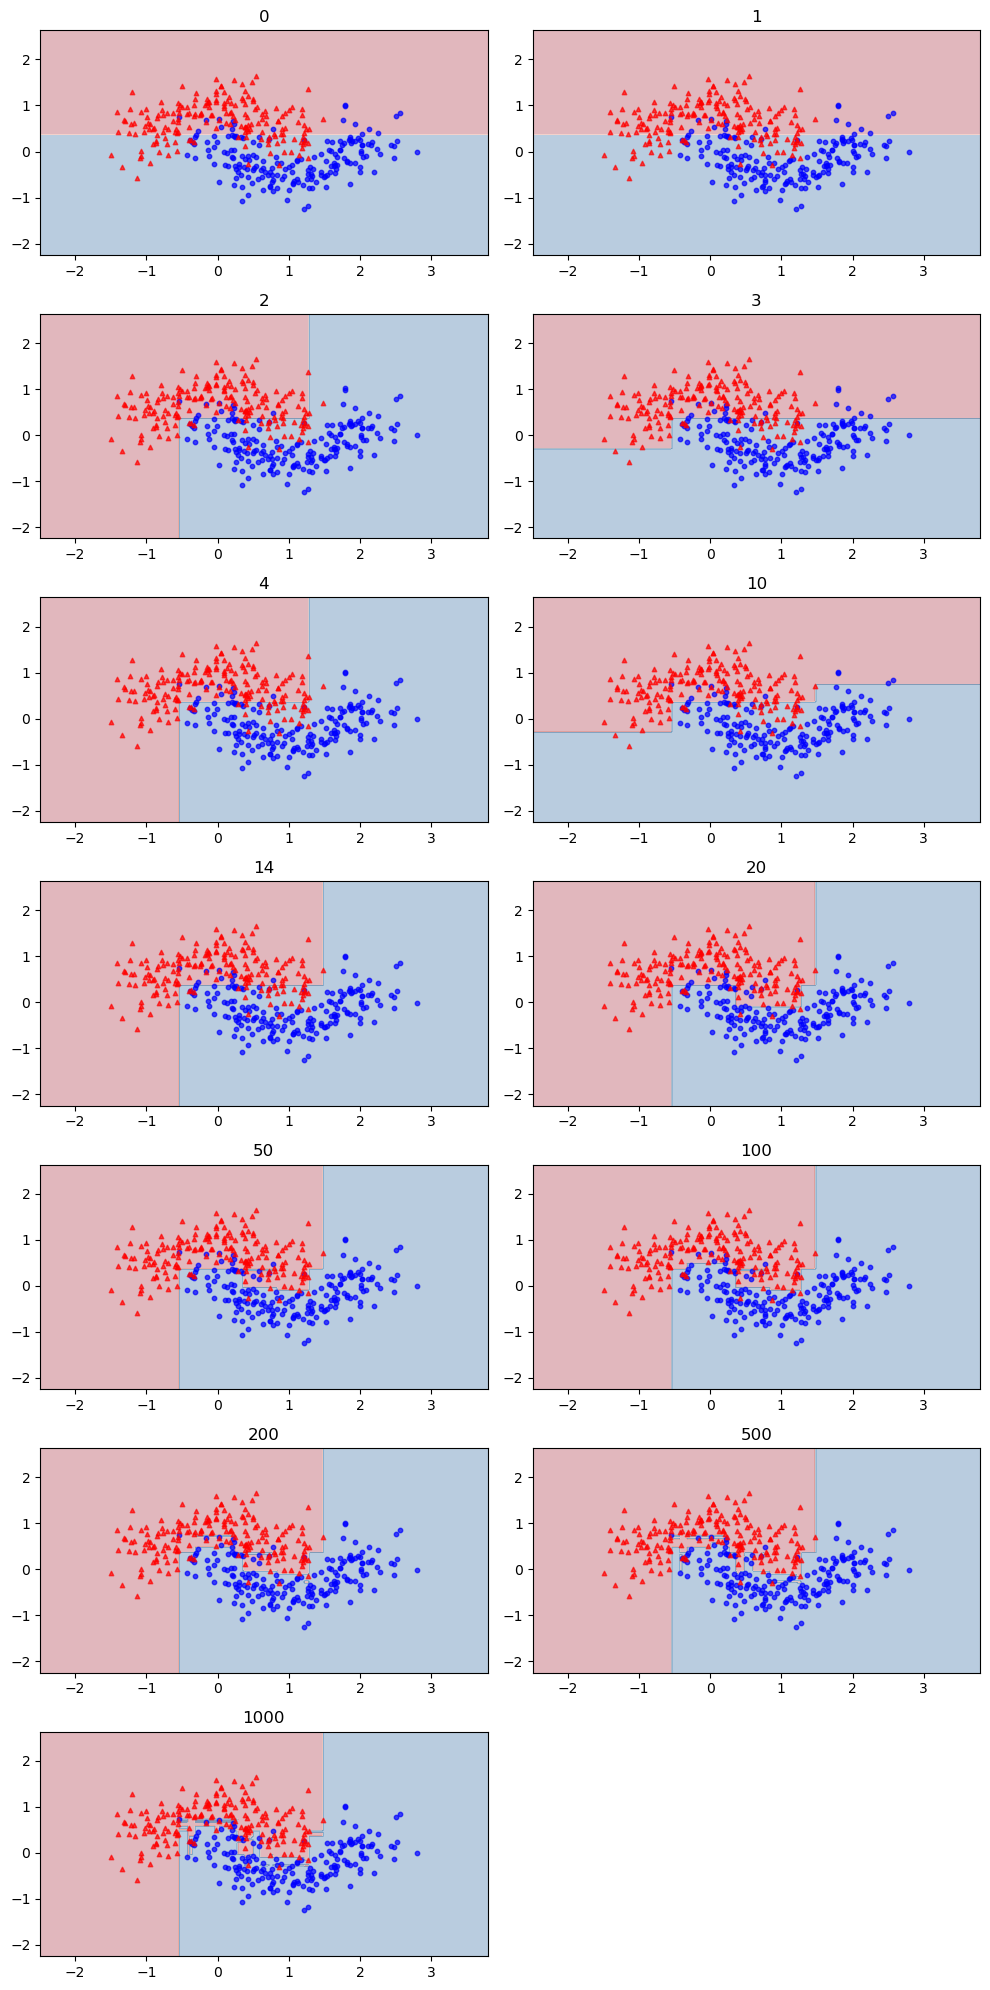

In [26]:
plt.figure(figsize=(10, 20))
for i, idx in enumerate([0, 1, 2, 3, 4, 10, 14, 20, 50, 100, 200, 500, 1000]):
    plt.subplot(7, 2, i+1)
    
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    ensemble_preds = np.zeros(mesh_points.shape[0])
    
    for j in range(idx + 1):
        tree_pred = classifiers[j].predict(mesh_points)
        tree_pred = 2 * tree_pred - 1
        ensemble_preds += alphas[j] * tree_pred

    Z = (ensemble_preds > 0).astype(int)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                c='blue', marker='o', label='Class 0',
                s=10, alpha=0.7)
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
                c='red', marker='^', label='Class 1',
                s=10, alpha=0.7)
    
    plt.title(f"{idx}")
    plt.tight_layout()
plt.show()

10.

As the size of the ensemble progresses, we see that the boundaries start out simple and become more and more complex as the we progress. The ensembles allow a conglomerate of weak learners to ultimately form good decisions as the model makes better and better classifications. We see the weights of the points near the complex boundaries become more important as the model learns that those points are critical to setting the boundary between the two classes.